In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

In [13]:
%pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
data = pd.read_csv('amazon_alexa.csv')
data.head() 

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
data.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [8]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [9]:
data = data.dropna().reset_index()

In [11]:
data.shape

(3149, 6)

In [14]:
data['length'] = data['verified_reviews'].apply(len)
data.head()

,index,rating,date,variation,verified_reviews,feedback,length
0,0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [15]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: I sent it to my 85 year old Dad, and he talks to it constantly.
Length of review : 63
'length' column value : 63


### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [20]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


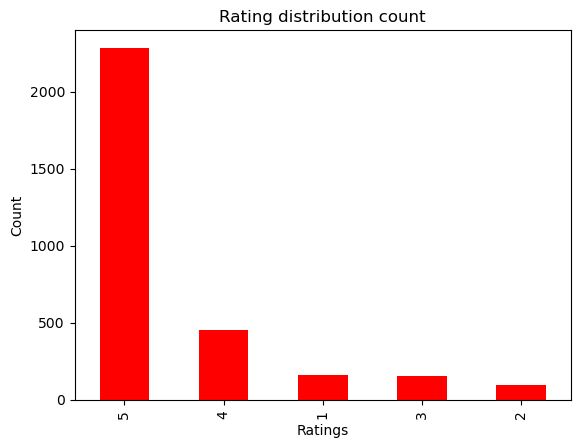

In [25]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [26]:
data.shape[0]*100

314900

In [34]:
print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()*(100/data.shape[0]),2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64%


<AxesSubplot:ylabel='Percentage wise distrubution of rating'>

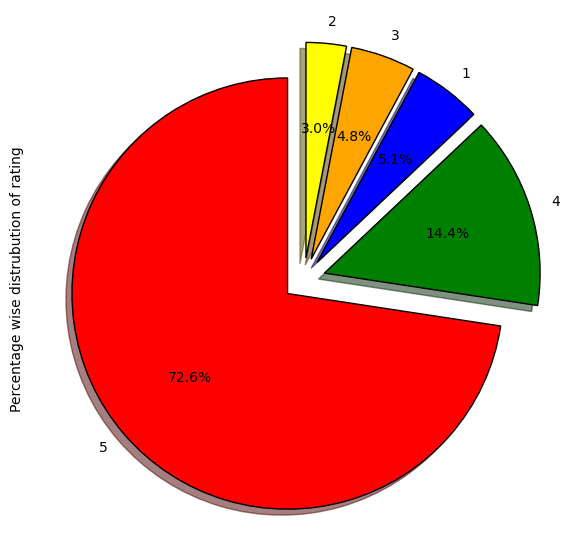

In [35]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')


In [36]:
#Distinct values of 'feedback' and its count 
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [38]:
data[data['feedback']==1]['verified_reviews']

0                                           Love my Echo!
1                                               Loved it!
2       Sometimes while playing a game, you can answer...
3       I have had a lot of fun with this thing. My 4 ...
4                                                   Music
                              ...                        
3144    Perfect for kids, adults and everyone in betwe...
3145    Listening to music, searching locations, check...
3146    I do love these things, i have them running my...
3147    Only complaint I have is that the sound qualit...
3148                                                 Good
Name: verified_reviews, Length: 2893, dtype: object

In [39]:
data[data['feedback']==0]['verified_reviews']

46      It's like Siri, in fact, Siri answers more acc...
111     Sound is terrible if u want good music too get...
141                                    Not much features.
162     Stopped working after 2 weeks ,didn't follow c...
176                                  Sad joke. Worthless.
                              ...                        
3046    Echo Dot responds to us when we aren't even ta...
3047                NOT CONNECTED TO MY PHONE PLAYLIST :(
3066    The only negative we have on this product is t...
3090                                    I didn’t order it
3095    The product sounded the same as the emoji spea...
Name: verified_reviews, Length: 256, dtype: object

From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

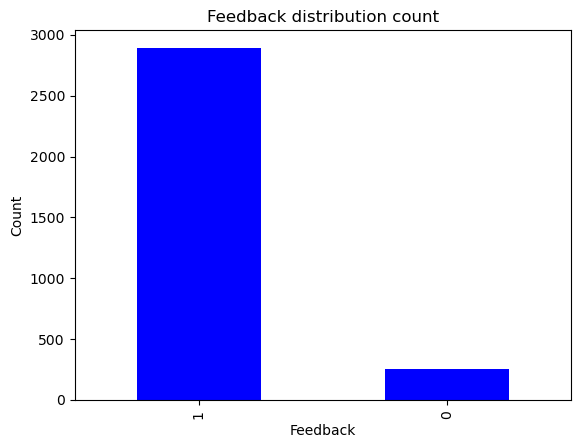

In [40]:
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [41]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [42]:
#Feedback = 0
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [43]:
#Distinct values of 'variation' and its count 

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


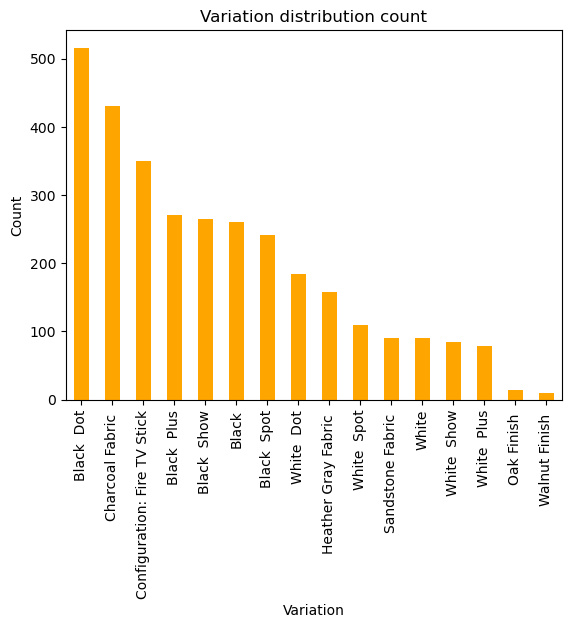

In [44]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [45]:
print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [46]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

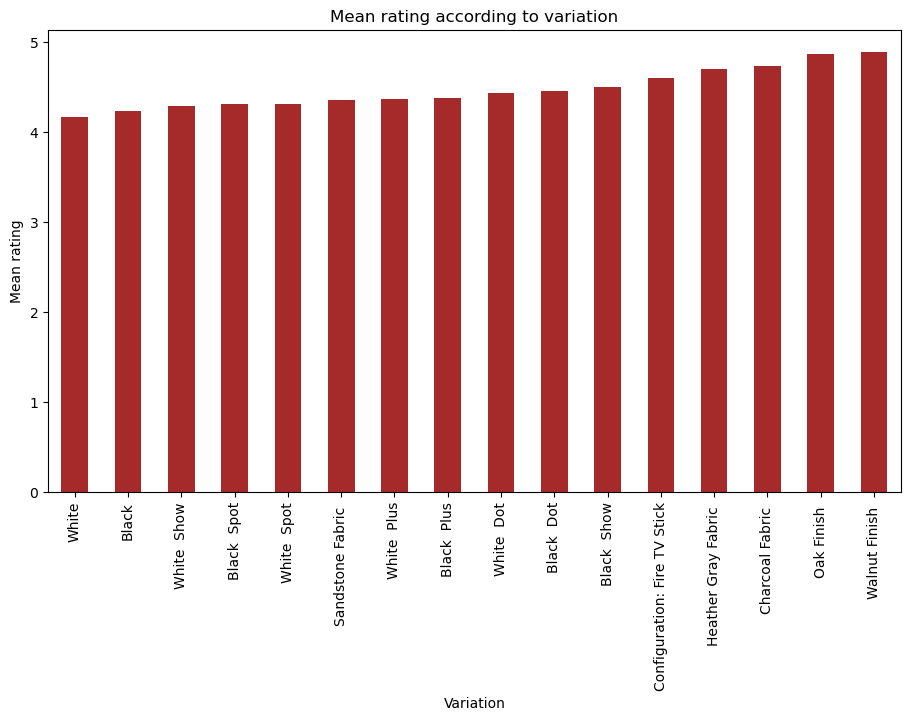

In [47]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

In [48]:
data['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

(array([2.781e+03, 2.660e+02, 7.200e+01, 1.800e+01, 6.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([1.000e+00, 2.860e+02, 5.710e+02, 8.560e+02, 1.141e+03, 1.426e+03,
        1.711e+03, 1.996e+03, 2.281e+03, 2.566e+03, 2.851e+03]),
 <BarContainer object of 10 artists>)

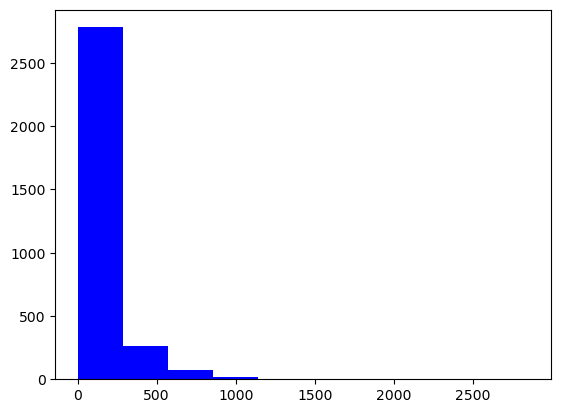

In [51]:
plt.hist(data['length'],color='blue')

(array([145.,  60.,  21.,  16.,   8.,   3.,   2.,   0.,   0.,   1.]),
 array([1.0000e+00, 1.6950e+02, 3.3800e+02, 5.0650e+02, 6.7500e+02,
        8.4350e+02, 1.0120e+03, 1.1805e+03, 1.3490e+03, 1.5175e+03,
        1.6860e+03]),
 <BarContainer object of 10 artists>)

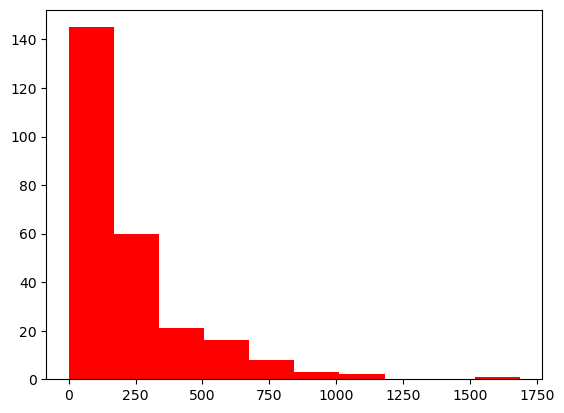

In [56]:
plt.hist(data[data['feedback']==0]['length'],color='red')

(array([2.593e+03, 2.230e+02, 5.300e+01, 1.300e+01, 6.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([1.000e+00, 2.860e+02, 5.710e+02, 8.560e+02, 1.141e+03, 1.426e+03,
        1.711e+03, 1.996e+03, 2.281e+03, 2.566e+03, 2.851e+03]),
 <BarContainer object of 10 artists>)

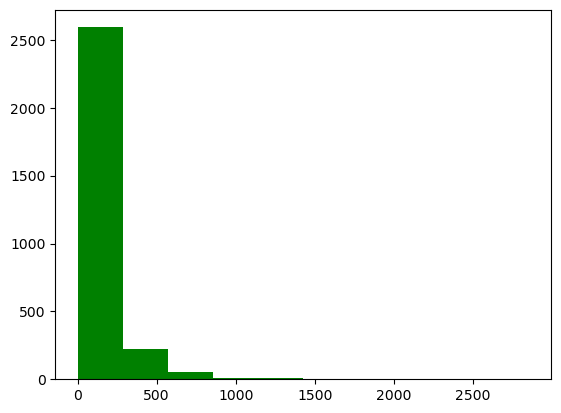

In [58]:
plt.hist(data[data['feedback']==1]['length'],color='green')

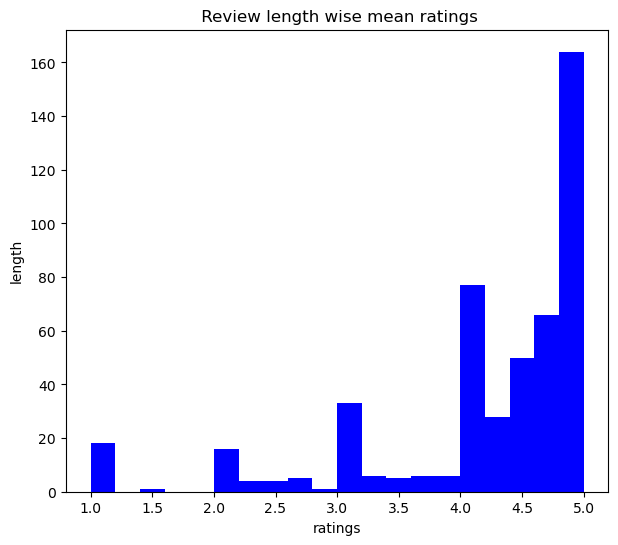

In [59]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

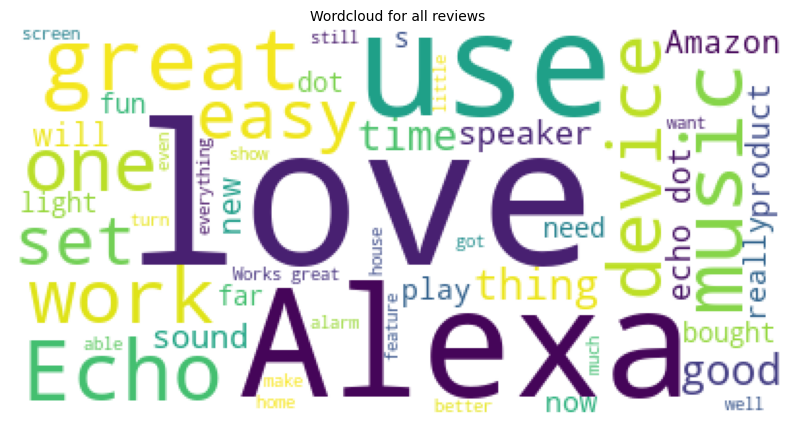

In [62]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

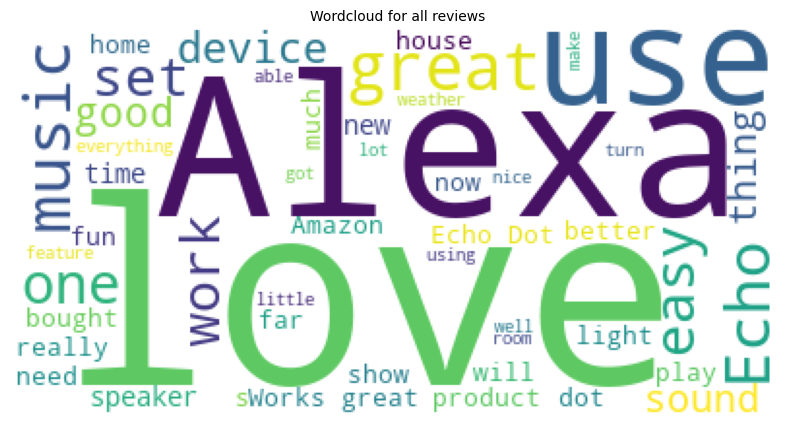

In [63]:
# positive feedback
reviews = " ".join([review for review in data[data["feedback"]==1]['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

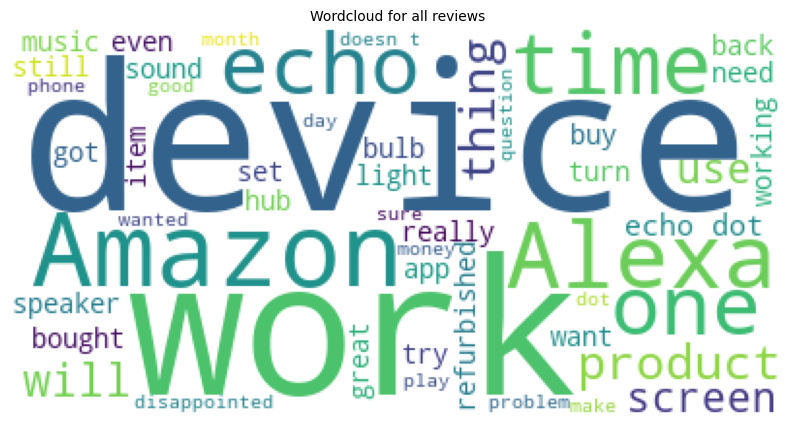

In [64]:
# negative feedback
reviews = " ".join([review for review in data[data["feedback"]==0]['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling


To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [66]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in stopwords.words("english")]
    review = ' '.join(review)
    corpus.append(review)

In [67]:
corpus

['love echo',
 'love',
 'sometim play game answer question correctli alexa say got wrong answer like abl turn light away home',
 'lot fun thing yr old learn dinosaur control light play game like categori nice sound play music well',
 'music',
 'receiv echo gift need anoth bluetooth someth play music easili access found smart speaker wait see els',
 'without cellphon cannot use mani featur ipad see use great alarm u r almost deaf hear alarm bedroom live room reason enough keep fun ask random question hear respons seem smartbon polit yet',
 'think th one purchas work get one everi room hous realli like featur offer specifili play music echo control light throughout hous',
 'look great',
 'love listen song heard sinc childhood get news weather inform great',
 'sent year old dad talk constantli',
 'love learn knew thing eveyday still figur everyth work far easi use understand make laugh time',
 'purchas mother knee problem give someth tri come get around fast like enjoy littl big thing ale

In [68]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [69]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [73]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


We'll scale X_train and X_test so that all values are between 0 and 1.

In [74]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [75]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [76]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9439153439153439


In [77]:
y_preds = model_rf.predict(X_test_scl)

In [79]:
cm = confusion_matrix(y_test, y_preds)

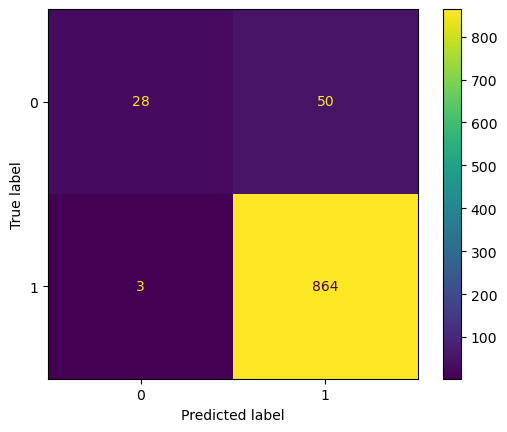

In [80]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [81]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9323981900452489
Standard Variance : 0.008930758862094062


Applying grid search to get the optimal parameters on random forest

In [82]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [84]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [85]:
#Getting the best parameters from the grid search

print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


#### XgBoost

In [87]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [88]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [89]:
y_preds = model_xgb.predict(X_test)

In [90]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 31  47]
 [ 13 854]]


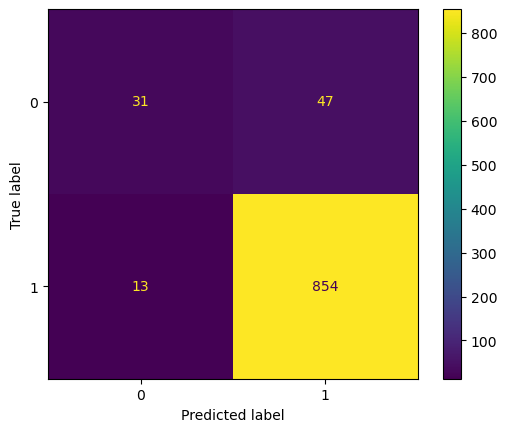

In [91]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [92]:
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

In [94]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [95]:
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [ ]:
def preprocess(data):
    corpus = []
    stemmer = PorterStemmer()
    for i in range(0, data.shape[0]):
        review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
        review = review.lower().split()
        review = [stemmer.stem(word) for word in review if not word in stopwords.words("english")]
        review = ' '.join(review)
        corpus.append(review)

In [ ]:
from sklearn.compose import ColumnTransformer
transform = ColumnTransformer([
    ()
])